# Graph Vr. of Co-Occurance based Clustering

### 1) Sample Data Preparation

In [1]:
import pandas as pd
from collections import defaultdict
from itertools import combinations

# Example DataFrame of posts with tags
data = {'post_id': [1, 2, 3, 4],
        'tags': [['python', 'pandas'], ['python', 'numpy'], ['java', 'spring'], ['python', 'java']]}
df = pd.DataFrame(data)

# Extract tag pairs
tag_pairs = defaultdict(int)
for tags in df['tags']:
    for pair in combinations(tags, 2):
        tag_pairs[tuple(sorted(pair))] += 1

# Convert to DataFrame
tag_pairs_df = pd.DataFrame(tag_pairs.items(), columns=['pair', 'count'])

In [2]:
df

,post_id,tags
0,1,"[python, pandas]"
1,2,"[python, numpy]"
2,3,"[java, spring]"
3,4,"[python, java]"


In [3]:
tag_pairs

defaultdict(int,
            {('pandas', 'python'): 1,
             ('numpy', 'python'): 1,
             ('java', 'spring'): 1,
             ('java', 'python'): 1})

In [4]:
tag_pairs_df

,pair,count
0,"(pandas, python)",1
1,"(numpy, python)",1
2,"(java, spring)",1
3,"(java, python)",1


### 2) Create Co-Occurance Matrix

In [5]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add edges with weights
for pair, count in tag_pairs.items():
    G.add_edge(pair[0], pair[1], weight=count)

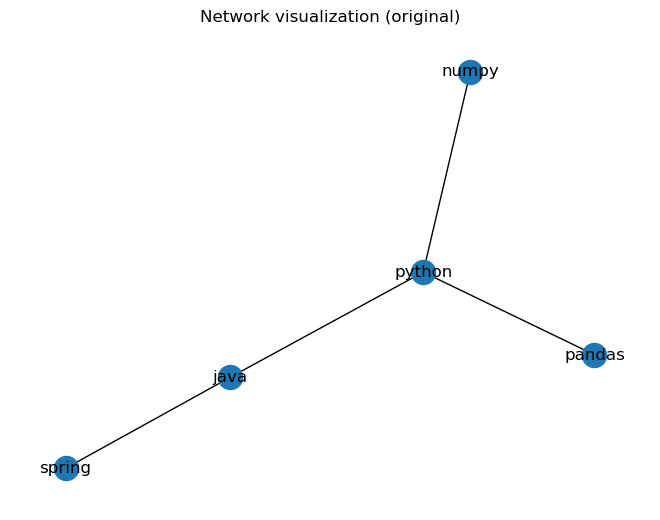

In [11]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
nx.draw(G, pos)
nx.draw_networkx_labels(G, pos, font_size=12)
# plt.savefig("filename.png")

plt.title("Network visualization (original)")
plt.show()

### Louvain Community Detection

In [15]:
import community as community_louvain

# Perform Louvain community detection
partition = community_louvain.best_partition(G, weight='weight')

# Print the communities
for tag, community_id in partition.items():
    print(f"Tag: {tag}, Community: {community_id}")

Tag: pandas, Community: 1
Tag: python, Community: 1
Tag: numpy, Community: 1
Tag: java, Community: 0
Tag: spring, Community: 0


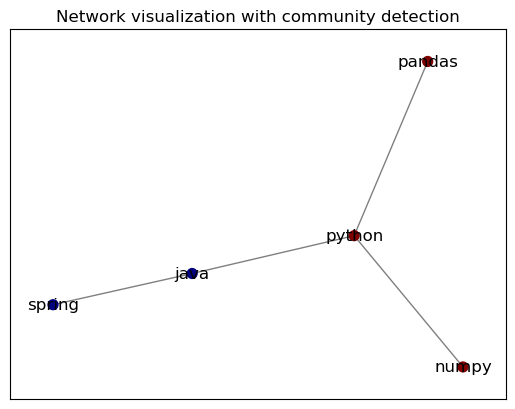

In [21]:
import matplotlib.pyplot as plt
# Get the communities
communities = defaultdict(list)
for node, community in partition.items():
    communities[community].append(node)

# Assign colors to communities
colors = {}
for community_id, nodes in communities.items():
    for node in nodes:
        colors[node] = community_id

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes

# Draw nodes
node_color = [colors[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap=plt.cm.jet, node_size=50)

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12)

plt.title("Network visualization with community detection")
plt.show()

### CuGraph Implementation using GPU

In [ ]:
import pandas as pd
from collections import defaultdict
from itertools import combinations
import cudf
import cugraph
import networkx as nx
import matplotlib.pyplot as plt

# Example DataFrame of posts with tags
# For your use case, replace this with actual data loading
data = {'post_id': range(40000),
        'tags': [list(f'tag{i}' for i in range(1, 6)) for _ in range(40000)]}
df = pd.DataFrame(data)

# Extract tag pairs
tag_pairs = defaultdict(int)
for tags in df['tags']:
    for pair in combinations(tags, 2):
        tag_pairs[tuple(sorted(pair))] += 1

# Convert tag pairs to a DataFrame
edges_df = pd.DataFrame(tag_pairs.items(), columns=['pair', 'count'])
edges_df[['source', 'target']] = pd.DataFrame(edges_df['pair'].tolist(), index=edges_df.index)
edges_df = edges_df[['source', 'target', 'count']]

# Create a cuDF DataFrame for cuGraph
gdf = cudf.DataFrame(edges_df)

# Create a graph using cuGraph
G = cugraph.Graph()
G.from_cudf_edgelist(gdf, source='source', destination='target', edge_attr='count')

# Perform Louvain community detection
parts, _ = cugraph.louvain(G)

# Convert the result back to a pandas DataFrame
parts = parts.to_pandas()

# Create a NetworkX graph for visualization
G_nx = nx.Graph()
for index, row in edges_df.iterrows():
    G_nx.add_edge(row['source'], row['target'], weight=row['count'])

# Assign colors to each community
communities = defaultdict(list)
for index, row in parts.iterrows():
    communities[row['partition']].append(row['vertex'])

colors = {}
for community_id, nodes in communities.items():
    for node in nodes:
        colors[node] = community_id

# Draw the graph
pos = nx.spring_layout(G_nx)  # positions for all nodes

# Draw nodes
node_color = [colors[node] for node in G_nx.nodes()]
nx.draw_networkx_nodes(G_nx, pos, node_color=node_color, cmap=plt.cm.jet, node_size=20)

# Draw edges
nx.draw_networkx_edges(G_nx, pos, width=0.5, alpha=0.5)

# Draw labels (optional, can be omitted for large graphs)
# nx.draw_networkx_labels(G_nx, pos, font_size=8)

plt.title("Network visualization with community detection (GPU)")
plt.show()


### Graph Visualization using GPU

In [ ]:
import pandas as pd
from collections import defaultdict
from itertools import combinations
import cudf
import cugraph
import dash
from dash import dcc, html
import plotly.graph_objs as go

# Example DataFrame of posts with tags
# For your use case, replace this with actual data loading
data = {'post_id': range(40000),
        'tags': [list(f'tag{i}' for i in range(1, 6)) for _ in range(40000)]}
df = pd.DataFrame(data)

# Extract tag pairs
tag_pairs = defaultdict(int)
for tags in df['tags']:
    for pair in combinations(tags, 2):
        tag_pairs[tuple(sorted(pair))] += 1

# Convert tag pairs to a DataFrame
edges_df = pd.DataFrame(tag_pairs.items(), columns=['pair', 'count'])
edges_df[['source', 'target']] = pd.DataFrame(edges_df['pair'].tolist(), index=edges_df.index)
edges_df = edges_df[['source', 'target', 'count']]

# Create a cuDF DataFrame for cuGraph
gdf = cudf.DataFrame(edges_df)

# Create a graph using cuGraph
G = cugraph.Graph()
G.from_cudf_edgelist(gdf, source='source', destination='target', edge_attr='count')

# Perform Louvain community detection
parts, _ = cugraph.louvain(G)

# Convert the result back to a pandas DataFrame
parts = parts.to_pandas()

# Create a dictionary for community colors
colors = {node: partition for node, partition in zip(parts['vertex'], parts['partition'])}

# Prepare data for Plotly
edge_trace = []
for edge in G.view_edge_list().to_pandas().itertuples(index=False):
    edge_trace.append(
        go.Scatter(
            x=[edge.src, edge.dst, None],
            y=[edge.src, edge.dst, None],
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines'
        )
    )

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Jet',
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Community',
            xanchor='left',
            titleside='right'
        ),
    )
)

for node in G.view_vertex_list().to_pandas()['vertex']:
    node_trace['x'] += tuple([node])
    node_trace['y'] += tuple([node])
    node_trace['text'] += tuple([str(node)])
    node_trace['marker']['color'] += tuple([colors[node]])

# Create Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(
        id='network-graph',
        figure={
            'data': edge_trace + [node_trace],
            'layout': go.Layout(
                title='Network Visualization with Community Detection (GPU)',
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0, l=0, r=0, t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            )
        }
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)
